In [2]:
# setup

import numpy as np, pickle
import matplotlib.pyplot as plt
from matplotlib import rcParams
import tensorflow as tf
from utils import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

params = {
   'axes.labelsize': 16,
   'font.size': 16,
   'legend.fontsize': 16,
   'xtick.labelsize': 13,
   'ytick.labelsize': 13,
   'text.usetex': False,
    'font.family':"sans-serif",
   'font.sans-serif':'Arial',
   'text.usetex': False,
   }

#mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
mnist = input_data.read_data_sets("data/fashion", one_hot=True)

rcParams.update(params)

C:\Python35\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/fashion\train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/fashion\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/fashion\t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/fashion\t10k-labels-idx1-ubyte.gz
Instru

In [3]:
pool = 4
d = int(784/pool**2)
lr = 0.1
lr2 = 500
batches = 8000
print_every = 100
num_channels=10
verbose=False

def HZ_reg(weights):
    d1, d2 = weights.shape
    d1, d2 = int(d1), int(d2)
    n_chan = d2//d1
    weights_rolled = tf.manip.roll(tf.reshape(weights,[d1,d1,n_chan]), shift=[-1], axis=[0])
    result = tf.reduce_mean(tf.abs(tf.reshape(weights,[d1,d1,n_chan])-weights_rolled))
    return result

def DZ_reg(weights):
    d1, d2 = weights.shape
    d1, d2 = int(d1), int(d2)
    n_chan = d2//d1
    weights_rolled = tf.manip.roll(tf.reshape(weights,[d1,d1,n_chan]), shift=[-1,-1], axis=[0,1])
    result = tf.reduce_mean(tf.abs(tf.reshape(weights,[d1,d1,n_chan])-weights_rolled))
    return result

In [105]:
tf.reset_default_graph()
x_train = tf.placeholder(tf.float32, [None, 784])
y_train = tf.placeholder(tf.float32, [None, 10])
x_valid = tf.placeholder(tf.float32, [None, 784])
y_valid = tf.placeholder(tf.float32, [None, 10])

alpha = get_variable([], initial=0.0)
beta = get_variable([], initial=0.0)

#hidden layer
W_fc1 = get_variable([d, d*num_channels])
b_fc1 = get_variable([d*num_channels])
W_fc2 = get_variable([d*num_channels, 10])
b_fc2 = get_variable([10])

def network(x):
    x_reshaped = tf.reshape(x, [-1, 28, 28, 1])
    x_reshaped = tf.nn.max_pool(x_reshaped, [1, pool, pool,1], [1, pool, pool, 1], padding='SAME')
    x_reshaped = tf.reshape(x_reshaped, [-1, d])
    h_fc1 = tf.nn.relu(tf.matmul(x_reshaped, W_fc1) + b_fc1)
    y_train_ = tf.matmul(h_fc1, W_fc2) + b_fc2
    return y_train_

y_train_ = network(x_train)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_train, logits=y_train_))
loss = loss + alpha * DZ_reg(W_fc1)
loss = loss + beta  * HZ_reg(W_fc1)

dW1 = tf.gradients(loss, W_fc1)[0]
db1 = tf.gradients(loss, b_fc1)[0]
dW2 = tf.gradients(loss, W_fc2)[0]
db2 = tf.gradients(loss, b_fc2)[0]

with tf.get_default_graph().control_dependencies([dW1, db1, dW2, db2]):
    updateW1 = tf.assign_sub(W_fc1, lr*dW1)
    updateb1 = tf.assign_sub(b_fc1, lr*db1)
    updateW2 = tf.assign_sub(W_fc2, lr*dW2)
    updateb2 = tf.assign_sub(b_fc2, lr*db2)
grp = tf.group(dW1, db1, dW2, db2, updateW1, updateb1, updateW2, updateb2)
    
def meta_network(x):
    x_reshaped = tf.reshape(x, [-1, 28, 28, 1])
    x_reshaped = tf.nn.max_pool(x_reshaped, [1, pool, pool,1], [1, pool, pool, 1], padding='SAME')
    x_reshaped = tf.reshape(x_reshaped, [-1, d])
    h_fc1 = tf.nn.relu(tf.matmul(x_reshaped, W_fc1 - lr*dW1) + b_fc1 - lr*db1)
    y_train_ = tf.matmul(h_fc1, W_fc2) + b_fc2
    return y_train_

y_valid_ = meta_network(x_valid)
meta_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_valid, logits=y_valid_))

dAlpha = tf.gradients(meta_loss, alpha)[0]
updateAlpha = tf.assign_sub(alpha, lr2*dAlpha)
dBeta = tf.gradients(meta_loss, beta)[0]
updateBeta = tf.assign_sub(beta, lr2*dBeta)

grp2 = tf.group(dAlpha, updateAlpha, dBeta, updateBeta)

losses = list()
alphas = list()
betas = list()

correct_prediction = tf.equal(tf.argmax(y_train, 1), tf.argmax(y_train_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as sess:
    tf.global_variables_initializer().run()        
    for i in range(batches):
        batch = mnist.train.next_batch(100)
        batch_valid = mnist.test.next_batch(100)
        
        sess.run(grp, feed_dict={x_train: batch[0], y_train: batch[1]})
        l = sess.run(loss, feed_dict={x_train: batch[0], y_train: batch[1]})
        sess.run(grp2, feed_dict={x_train: batch[0], y_train: batch[1],
                                      x_valid: batch_valid[0], 
                                      y_valid: batch_valid[1]})
        
        al = alpha.eval()        
        be = beta.eval()        
        weights = W_fc1.eval()
        
        if i%print_every==0:
            losses.append(l)
            alphas.append(al)
            betas.append(be)
            if verbose:
                print(i)
                print("Loss:",l)
                print('alpha:',al)
                print('beta:',be)
                
    accuracy_train = accuracy.eval(feed_dict={x_train: mnist.train.images[:1000], y_train: mnist.train.labels[:1000]})
    accuracy_valid = accuracy.eval(feed_dict={x_train: mnist.test.images, y_train: mnist.test.labels})

print(i)
print("Loss:",l)
print('alpha:',al)
print('beta:',be)  

print("Training accuracy:",accuracy_train)
print("Validation accuracy:",accuracy_valid)

7999
Loss: 5.0764
alpha: 81.34038
beta: 6.3661156
Training accuracy: 0.754
Validation accuracy: 0.7291


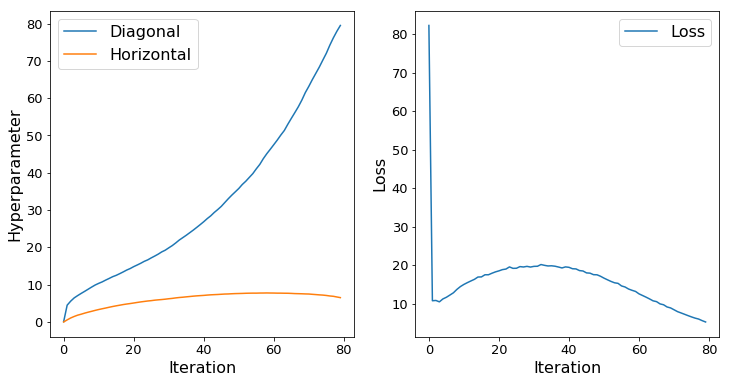

In [106]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.plot(alphas, label='Diagonal')
plt.plot(betas, label='Horizontal')
plt.ylabel('Hyperparameter')
plt.xlabel('Iteration')
plt.legend()
plt.subplot(1,2,2)
plt.plot(losses, label='Loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend()

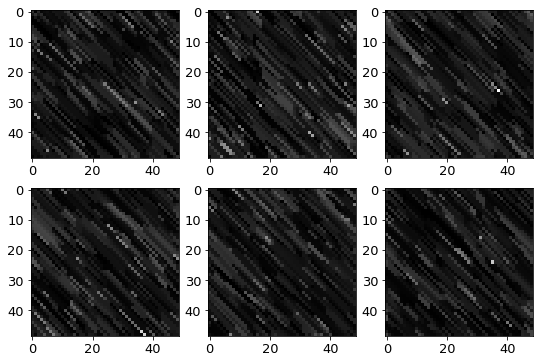

In [107]:
visualize_general_weights(weights, num_channels=num_channels, pool=pool)